# Sprint 12 - Numerical Methods

## Project Description 

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

**Rusty Bargain is interested in:**

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Project Requirements

**The goal of this project is to**
 - Train different models with various hyperparameters. The goal is to compare gradient boosting methods with random forest, decision tree, and linear regression. 
 
**As set forth by the project prompt, we will want to make sure to complete the following -**
 - We'll want to analyze the speed and quality of the models.
   - Use the RMSE metric to evaluate the models.
 - Linear regression is not very good for hyperparameter tuning, but it is perfect for doing a sanity check of other methods. If gradient boosting performs worse than linear regression, something definitely went wrong.
 - The project should include linear regression for a sanity check, a tree-based algorithm with hyperparameter tuning (preferably, random forrest), LightGBM with hyperparameter tuning (try a couple of sets), and CatBoost and XGBoost with hyperparameter tuning (optional).
 - Take note of the encoding of categorical features for simple algorithms. LightGBM and CatBoost have their implementation, but XGBoost requires OHE.
 - Use a special command to find the cell code runtime in Jupyter Notebook. 
 - Since the training of a gradient boosting model can take a long time, change only a few model parameters.

## Import Libraries

In [1]:
# Import libraries required for analysis 
import numpy as np
import pandas as pd

# For Train, Test, Split
from sklearn.model_selection import train_test_split

# For Scaling
from sklearn.preprocessing import StandardScaler

# For RMSE
from sklearn.metrics import mean_squared_error

# For Determining Processing Length
from time import process_time 

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Grid Search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

# https://lightgbm.readthedocs.io/en/stable/Python-Intro.html
from lightgbm import LGBMRegressor

# https://catboost.ai/en/docs/concepts/python-usages-examples
from catboost import CatBoostRegressor

#https://xgboost.readthedocs.io/en/stable/python/python_api.html
from xgboost import XGBRegressor

Cell below is used to align the tables in the markdown to the left

In [2]:
%%html
<style>
table {float:left}
</style>

## Data Preparation

### Read in Dataset

In [3]:
# Read in data csv and convert to dataframe
car_data = pd.read_csv('/datasets/car_data.csv')

### Data Description
*Below is a description of the fields found in the dataset -*

**Features**
 - **DateCrawled —** date profile was downloaded from the database
 - **VehicleType —** vehicle body type
 - **RegistrationYear —** vehicle registration year
 - **Gearbox —** gearbox type
 - **Power —** power (hp)
 - **Model —** vehicle model
 - **Mileage —** mileage (measured in km due to dataset's regional specifics)
 - **RegistrationMonth —** vehicle registration month
 - **FuelType —** fuel type
 - **Brand —** vehicle brand
 - **NotRepaired —** vehicle repaired or not
 - **DateCreated —** date of profile creation
 - **NumberOfPictures —** number of vehicle pictures
 - **PostalCode —** postal code of profile owner (user)
 - **LastSeen —** date of the last activity of the user

**Target**
 - **Price —** price (Euro)

### View Sample of Dataset

In [4]:
car_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


### Explore Dataset

In [5]:
# Use print so I don't lose outputs

# Check for missing values
print('Check for Missing Values')
print(car_data.isna().sum())
print()

# Check for duplicate rows
print('Check for Duplicate Rows')
print('There are', car_data.duplicated().sum(), 'duplicate rows')
print()

# Check values for each column
print('\n Describe Dataframe')
print(car_data.describe())
print()

# Check data types
print('\n Check Data Types')
print(car_data.info())
print()

Check for Missing Values
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Check for Duplicate Rows
There are 262 duplicate rows


 Describe Dataframe
               Price  RegistrationYear          Power        Mileage  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000 

### Data Exploration Summary

**After performing an EDA on the car dataset, these are the finding -**
 - There are missing values in the fields - `VehicleType`,`Gearbox`,`Model`,`FuelType`,`NotRepaired`
     - These fields are all categorical data as their datatype is object. These can be replace with the string `Unknown` since we cannot extrapolate what these values may actually be. There are 354,369 total rows and missing values represent at a minimum up to 71,154 rows which is approximately 20% of the total rows. For this reason we cannot drop these rows as it would make our sample too small. We will need to replace these missing values.
 - `DateCrawled` is when the date profile was downloaded from the database. This has no affect on the car's price and can be dropped from the feature set. 
     - There are a few other fields that can be dropped that will not have an affect on predicting car price
         - Those fields are `DateCreated`, `RegistrationMonth`, `PostalCode`, `LastSeen`
 - There are 262 duplicate rows in the dataset. While this may not have a large impact on the model, one row of each duplicate pair of rows should be dropped. 
 - `NumberOfPictures` only has values of 0. This column should be dropped because add any value to training our model. 

**After we have a "cleaned" dataset, we are going to need to make additional transformations so that we can train a model on it.**

### Make Any Necessary Changes to Dataset After EDA

#### Replace Missing Values With `Unknown`

In [6]:
# Replace missing values with Unknown
car_data.fillna('Unknown', inplace=True)

# Check for missing values after replacement
car_data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

#### Drop Duplicates

In [7]:
# Drop one of the duplicate rows
car_data.drop_duplicates(keep = 'first', inplace = True)

# Check for duplicate rows after drop
print('There are', car_data.duplicated().sum(), 'duplicate rows')

There are 0 duplicate rows


#### Drop Fields
Remove fields that will not have impact on predicting price

In [8]:
# Drop fields from dataframe
car_data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'NumberOfPictures', 'LastSeen'], axis=1, inplace = True)

# Check if columns were dropped
car_data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Mileage', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

## Creating Training, Validation & Test Data
Before we train our models, we need to do a few things -
 - Encode categorical fields so that the models can use these fields when predicting price
 - Split dataset into three data sets - training, validation, test. This way we can use the validation and training sets to find the best hyperparameters and then present the model with a new dataset where it doesn't know the targets.
 - Scale certain fields where the numerical values are too large. We don't want the model putting too much weight on mileage, which could be thousands of times larger than binary values like vehicle type convertible (0/1)

### Encode Categorical Fields 
Because there isn't a ranking or order to the categorical fields that need to be perserved when converting to numerical values, we will use OHE instead of ordinal encoding. 

In [9]:
# Create a list of the columns that need to be converted
categorical_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']

# Convert categorical fields to numerical fields using OHE
# Not removing dummy variables because the categorical fields are not binary (1/0)
car_data_ohe = pd.get_dummies(car_data, columns=categorical_columns, drop_first=False)

# Print sample of encoded data frame
car_data_ohe.head()

,Price,RegistrationYear,Power,Mileage,VehicleType_Unknown,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_Unknown,NotRepaired_no,NotRepaired_yes
0,480,1993,0,150000,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,18300,2011,190,125000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1500,2001,75,150000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,3600,2008,69,90000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Split Data Into Training, Validation & Test
Because we need to do hyperparameter tuning, we will need to create a few sets of training data to fit and evaluate the model on

In [10]:
# The validiation set will be split in half to get 3 datasets with a ration of 3:1:1
# Set Random State to 12345 to Replicate Training Set in Future
# 60% of data will be in training_set and other 40% will be in validation_set_to_split
training_set, validation_set_to_split = train_test_split(car_data_ohe, test_size=0.40, random_state=12345)

# Split validation_set_to_split in half to create a validation and test set
validation_set, test_set = train_test_split(validation_set_to_split, test_size=0.50, random_state=12345)

# Create the features and target training datasets
features_train = training_set.drop(['Price'], axis=1)
target_train = training_set['Price']

# Create the features and target validation datasets
features_valid = validation_set.drop(['Price'], axis=1)
target_valid = validation_set['Price']

# Create the features and target test datasets
features_test = test_set.drop(['Price'], axis=1)
target_test = test_set['Price']

#Training 
print(features_train.shape) # Training set contains 60% of original dataframe rows 
print(target_train.shape)   # Training set contains 60% of original dataframe rows 

# Validation
print(features_valid.shape) # Validation set contains 25% of original dataframe rows 
print(target_valid.shape)   # Validation set contains 25% of original dataframe rows 

# Test
print(features_test.shape)  # Test set contains 25% of original dataframe rows 
print(target_test.shape)    # Test set contains 25% of original dataframe rows 

# Test & Validation Sets Aren't Same Shape So Dropping Last Row of Test
test_set.drop(test_set.tail(1).index,inplace=True) 

(212464, 317)
(212464,)
(70821, 317)
(70821,)
(70822, 317)
(70822,)


/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Perform Scaling

In [11]:
#### Updated Scaling Based on Comments

# Create a list of features that need to be scaled
# Scaling is needed because these values are much larger than 0/1 and we don't want the model to overfit for these features
features_to_scale = [ 'RegistrationYear', 'Power', 'Mileage']

# Fit StandardScaler to scale features for training set only
# Then apply the same scaler to transform all three sets (train, validation and test)
# The scaler is never fit using validation/test data
transformer = StandardScaler().fit(features_train[features_to_scale].to_numpy())

# Create a copy of df with scaled/transformed features 
# Apply the same scaler to transform all three sets (train, validation and test) using transformer
# Train
features_train_scaled = features_train.copy()
features_train_scaled.loc[:, features_to_scale] = transformer.transform(features_train[features_to_scale].to_numpy())

# Train
features_valid_scaled = features_valid.copy()
features_valid_scaled.loc[:, features_to_scale] = transformer.transform(features_valid[features_to_scale].to_numpy())

# Test
features_test_scaled = features_test.copy()
features_test_scaled.loc[:, features_to_scale] = transformer.transform(features_test[features_to_scale].to_numpy())

# Print sample of scaled trained dataset
print('Train')
display(features_train_scaled.head())

print('Validation')
display(features_valid_scaled.head())

print('Test')
display(features_test_scaled.head())

Train


,RegistrationYear,Power,Mileage,VehicleType_Unknown,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_Unknown,NotRepaired_no,NotRepaired_yes
62746,0.030174,-0.208856,-0.085235,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
324587,0.008102,-0.267675,-1.538183,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
89315,-0.036042,-0.267675,0.575197,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
217912,0.151569,-0.278369,-1.274011,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
202884,-0.036042,0.160097,0.575197,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


Validation


,RegistrationYear,Power,Mileage,VehicleType_Unknown,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_Unknown,NotRepaired_no,NotRepaired_yes
16821,0.008102,0.609257,0.575197,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
257640,-0.069150,-0.588503,0.575197,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
270959,0.030174,0.160097,0.575197,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
58062,-0.036042,-0.278369,0.575197,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
288828,-0.069150,-0.027053,0.575197,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


Test


,RegistrationYear,Power,Mileage,VehicleType_Unknown,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_Unknown,NotRepaired_no,NotRepaired_yes
10918,0.052246,-0.310452,0.575197,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
74151,0.107425,0.213568,-2.594873,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
222436,-0.091222,-0.187468,-1.274011,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
58607,0.019138,-0.508296,-3.123218,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
236615,-0.047078,0.138708,0.575197,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Print Shape of Training Sets

In [13]:
print('Training')
features_train = features_train_scaled.reset_index(drop = True)
target_train = target_train.reset_index(drop = True)
print('Training Features:', features_train.shape)
print('Training Target:', target_train.shape)

print()
print('Validation')
features_valid = features_valid_scaled.reset_index(drop = True)
target_valid = target_valid.reset_index(drop = True)
print('Validation Features:', features_valid.shape)
print('Validation Target:', target_valid.shape)

print()
print('Test')
features_test = features_test_scaled.reset_index(drop = True)
target_test = target_test.reset_index(drop = True)
print('Test Features:', features_test.shape)
print('Test Target:', target_test.shape)

Training
Training Features: (212464, 317)
Training Target: (212464,)

Validation
Validation Features: (70821, 317)
Validation Target: (70821,)

Test
Test Features: (70822, 317)
Test Target: (70822,)


## Modeling & Evaluation

**For the modeling & evaluation section please note that -**
- Model performance will be evaluated based on time elapsed and RMSE
- For the RandomForrest, LightGBM,CatBoost, XGBoost I will tune models to find the optimal n_estimators and depth using GridSearchCV
- The LinearRegression model will serve as a baseline to compare other regression models to. Because we aren't going to do any tuning on the LinearRegression Model, we can fit to training data set and predict on test data without using the validation set. 
- **I will provide a table of model timings and results in the following section so that I can select a model an evaluate its performance on the test data.**

### LinearRegression - Baseline
The LinearRegression model will serve as a baseline to compare other regression models to. We aren't going to do any tuning on the LinearRegression Model.

In [14]:
%%time 

# Initialize Model
model = LinearRegression()

# Fit Model to Training Data
model.fit(features_train, target_train)

# Predict Test Target
predicted_values = model.predict(features_valid)

# Calculate RMSE
RMSE = np.sqrt(mean_squared_error(target_valid, predicted_values))

# Print RMSE Score
print('The RMSE for the LinearRegression Model is:', round(RMSE,2))

# Print Time Elapsed For Model Runtime
print('Run Time for LinearRegression:')

The RMSE for the LinearRegression Model is: 3183.09
Run Time for LinearRegression:
CPU times: user 15.2 s, sys: 2.31 s, total: 17.6 s
Wall time: 17.6 s


### Model Evaluation Function

In this section, I have created a function that takes the model and the model name, **and the function will return -**
  - Time to find best hyperparamters using training dataset including time to predict target values on validation set
  - Function will print best hyperparameters that generated the best RMSE on training set
  - Function will print RMSE on training dataset
  - Function will print RMSE on validation dateset using hyperparamters found in tuning

This function will allow me to avoid code duplication and it will train all of the models using the same search space so that we can equally compare all models. **In the following sections I will plug in the names of the models to this function so that I can obtain timings and values. I will compare these values and timings after all models have been tuned so that I can select a model that I can use to predict test targets.**



In [15]:
# Create model evaluation function 
# For model tuning, we will use GridSearchCV and keep the search space constant across models
def model_evaluation(model,model_name):
    
    # Create a search space to optimize for best combination of n_estimators and max_depth
    search_space = {'n_estimators': [5,10,20]
                    , 'max_depth': [5,10,20]}
       
    # Initialize Model
    model = model

    # Create a GridSearchCV Object
    # Use 3-fold cross validation (5 is the default, but to save time on training, we will use 3-fold)
    # Select Best Model Using neg_root_mean_squared_error as Scorer function 
    model_grid = GridSearchCV(model, param_grid = search_space, cv = 3, scoring = 'neg_root_mean_squared_error', verbose = 0)

    # Fit model to training data
    model_grid.fit(features_train, target_train)

    # Save best parameters to variable that produce the smallest RMSE
    # best_parameters will contain a dictionary of the best parameters that produced the lowest RMSE
    best_parameters = model_grid.best_params_

    # Best score is the RMSE value on the training data
    best_score = model_grid.best_score_

    # Best grid will contain the parameters that can be used to predict values on the validation set
    # The refitted estimator is made available at the best_estimator_ attribute and permits using predict directly on this GridSearchCV instance
    best_grid = model_grid.best_estimator_

    # Predict target values on the validation set
    predicted_values = best_grid.predict(features_valid)

    # Calculate RMSE between predicted target and actual target for validation set
    RMSE = np.sqrt(mean_squared_error(target_valid, predicted_values))

    # Print results of tuning and RMSE on validation set 
    # Also print time for training and calculating RMSE on validation data 
    print("Best Parameters For", model_name,":", best_parameters )
    print("These Parameters Produced a Best RMSE Score of", round(best_score,2), "on the Training Data")
    print()
    print("The RMSE Using the Tuned", model_name, "on the Validation Set:", round(RMSE,2))
    #print("Best grid:", best_grid )
    print()
    print('Training Time for', model_name,':')

#### RandomForrest
Evaluate the performance of a tree-based algorithm with hyperparameter tuning. **Random Forest Regression** is a versatile machine-learning technique for predicting numerical values. It combines the predictions of multiple decision trees to reduce overfitting and improve accuracy.

**PLEASE NOTE -** Hyperparameter Tuning of the Random Took 11 Minutes and 34 Seconds to Run for RandomForestRegressor. **I'm commenting this out to make the notebook run faster.** Screeshot included of model output to save time when reviewing.

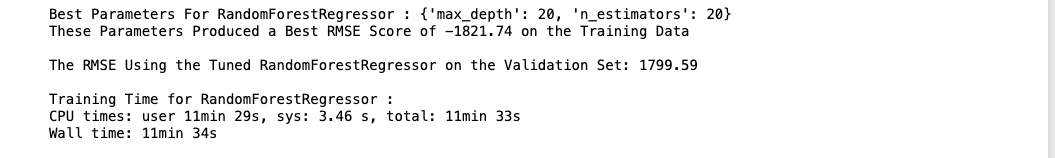

In [16]:
# %%time

# # Set variables to RandomForestRegressor
# model = RandomForestRegressor()
# model_name = 'RandomForestRegressor'

# # Configure model_evaluation to use RandomForestRegressor
# model_evaluation(model, model_name)

#### LightGBM
**LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

 - Faster training speed and higher efficiency.
 - Lower memory usage.
 - Better accuracy.
 - Support of parallel, distributed, and GPU learning.
 - Capable of handling large-scale data.

In [17]:
%%time

# Set variables to LGBMRegressor
model = LGBMRegressor(random_state=12345)
model_name = 'LGBMRegressor'

# Configure model_evaluation to use LGBMRegressor
model_evaluation(model, model_name)

Best Parameters For LGBMRegressor : {'max_depth': 20, 'n_estimators': 20}
These Parameters Produced a Best RMSE Score of -2215.6 on the Training Data

The RMSE Using the Tuned LGBMRegressor on the Validation Set: 2215.34

Training Time for LGBMRegressor :
CPU times: user 1min, sys: 4.84 s, total: 1min 5s
Wall time: 1min 5s


#### CatBoost

**CatBoost** is a popular and high-performance open-source implementation of the Gradient Boosting Decision Tree (GBDT) algorithm. GBDT is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. CatBoost introduces two critical algorithmic advances to GBDT:

 - The implementation of ordered boosting, a permutation-driven alternative to the classic algorithm
 - An innovative algorithm for processing categorical features

Both techniques were created to fight a prediction shift caused by a special kind of target leakage present in all currently existing implementations of gradient boosting algorithms.

In [18]:
%%time

# Set variables to CatBoostRegressor
model = CatBoostRegressor(random_state=12345)
model_name = 'CatBoostRegressor'

# Configure model_evaluation to use CatBoostRegressor
model_evaluation(model, model_name)

Learning rate set to 0.5
0:	learn: 3320.9370137	total: 75.3ms	remaining: 301ms
1:	learn: 2761.9456083	total: 103ms	remaining: 154ms
2:	learn: 2547.3067382	total: 129ms	remaining: 86.2ms
3:	learn: 2401.0539361	total: 154ms	remaining: 38.5ms
4:	learn: 2337.3639390	total: 179ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3376.1848971	total: 25.1ms	remaining: 100ms
1:	learn: 2827.7314296	total: 48.7ms	remaining: 73ms
2:	learn: 2580.8315429	total: 71ms	remaining: 47.3ms
3:	learn: 2433.8546925	total: 93.3ms	remaining: 23.3ms
4:	learn: 2356.8824173	total: 116ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3311.7829335	total: 24.1ms	remaining: 96.4ms
1:	learn: 2759.2263055	total: 50.3ms	remaining: 75.4ms
2:	learn: 2549.1449656	total: 76.9ms	remaining: 51.2ms
3:	learn: 2409.9883189	total: 100ms	remaining: 25.1ms
4:	learn: 2327.8183273	total: 125ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3320.9370137	total: 25.9ms	remaining: 233ms
1:	learn: 2761.9456083	total: 54.8ms	remaini

9:	learn: 1941.6284777	total: 825ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3133.8919961	total: 84ms	remaining: 1.6s
1:	learn: 2523.6405837	total: 167ms	remaining: 1.5s
2:	learn: 2280.6286159	total: 244ms	remaining: 1.39s
3:	learn: 2149.7853386	total: 328ms	remaining: 1.31s
4:	learn: 2074.4108560	total: 417ms	remaining: 1.25s
5:	learn: 2028.2602747	total: 493ms	remaining: 1.15s
6:	learn: 2003.9926351	total: 582ms	remaining: 1.08s
7:	learn: 1971.5288390	total: 668ms	remaining: 1s
8:	learn: 1947.6009832	total: 743ms	remaining: 908ms
9:	learn: 1937.9607647	total: 827ms	remaining: 827ms
10:	learn: 1923.5219360	total: 907ms	remaining: 742ms
11:	learn: 1909.6830317	total: 988ms	remaining: 659ms
12:	learn: 1901.5338510	total: 1.08s	remaining: 580ms
13:	learn: 1888.1789187	total: 1.15s	remaining: 492ms
14:	learn: 1880.8492346	total: 1.23s	remaining: 411ms
15:	learn: 1871.4692521	total: 1.31s	remaining: 328ms
16:	learn: 1860.7713799	total: 1.4s	remaining: 247ms
17:	learn: 1848.5477190

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

Learning rate set to 0.5
0:	learn: 3169.4061350	total: 123ms	remaining: 2.34s
1:	learn: 2539.2936830	total: 239ms	remaining: 2.15s
2:	learn: 2283.4383329	total: 359ms	remaining: 2.04s
3:	learn: 2133.2747651	total: 486ms	remaining: 1.95s
4:	learn: 2068.8583083	total: 604ms	remaining: 1.81s
5:	learn: 2027.5293342	total: 726ms	remaining: 1.69s
6:	learn: 2002.4523238	total: 843ms	remaining: 1.57s
7:	learn: 1978.8707255	total: 956ms	remaining: 1.43s
8:	learn: 1963.6295935	total: 1.07s	remaining: 1.31s
9:	learn: 1945.1238258	total: 1.2s	remaining: 1.2s
10:	learn: 1934.8902348	total: 1.32s	remaining: 1.08s
11:	learn: 1926.7705900	total: 1.44s	remaining: 959ms
12:	learn: 1916.9716188	total: 1.55s	remaining: 838ms
13:	learn: 1904.4593286	total: 1.68s	remaining: 720ms
14:	learn: 1896.8080137	total: 1.79s	remaining: 596ms
15:	learn: 1882.8345633	total: 1.91s	remaining: 477ms
16:	learn: 1870.4195233	total: 2.03s	remaining: 358ms
17:	learn: 1865.1188510	total: 2.14s	remaining: 238ms
18:	learn: 1859

#### XGBoost
**XGBoost** is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

**PLEASE NOTE -** Hyperparameter Tuning of the Random Took 39 Minutes and 45 Seconds to Run for XGBRegressor. **I'm commenting this cell out to make the notebook run faster.** Screeshot included of model output to save time when reviewing.

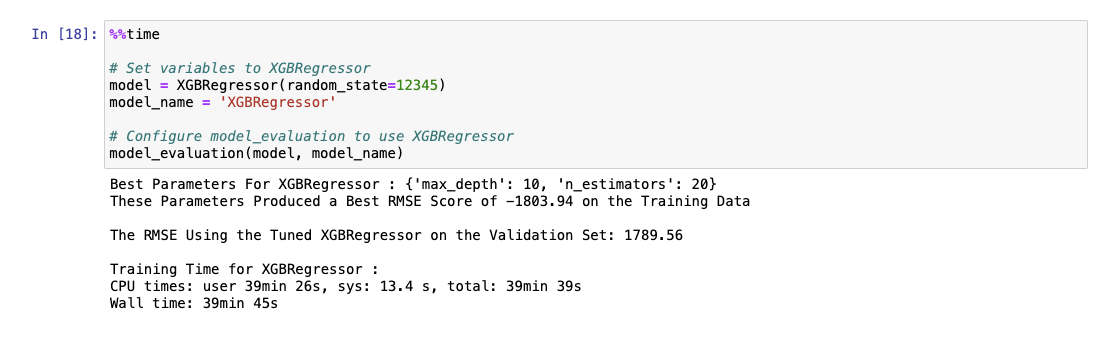

In [19]:
# %%time

# # Set variables to XGBRegressor
# model = XGBRegressor(random_state=12345)
# model_name = 'XGBRegressor'

# # Configure model_evaluation to use XGBRegressor
# model_evaluation(model, model_name)

## Model Training Analysis 

**Rusty Bargain is interested in -**

- the quality of the prediction
- the speed of the prediction
- the time required for training

**Here is a table that contains the results of the previous section -**

| Model            | RMSE When Predicting Targets on Validation Set | Time Required for Training                                               | Hyperparameter Tuning Notes         |
|------------------|------------------------------------------------|--------------------------------------------------------------------------|-------------------------------------|
| LinearRegression |                     3185.29                    | N/A - No Tuning Required For Finding Baseline RMSE                       | N/A                                 |
| **RandomForrest**    |                     1799.59                    | 11 mins 29 seconds When Optimizing For max_depth & n_estimators          | max_depth = 20 \| n_estimators = 20 |
| LightGBM         |                     2215.34                    | 2min 29s seconds When Optimizing For max_depth & n_estimators             | max_depth = 20 \| n_estimators = 20 |
| **CatBoost**         |                     1895.01                    | 43 seconds When Optimizing For max_depth & n_estimators                | max_depth = 10 \| n_estimators = 20 |
| XGBoost          |                       1789.56                      | 39 mins 45 seconds When Optimizing For max_depth & n_estimators | max_depth = 10 \| n_estimators = 20   |

Given Rusty Bargain's requirements for model selection, the best model for predicting the market value of your car would either **CatBoost or the RandomForestRegressor**. The RandomForestRegressor has an RMSE when predicting targets on the validation set of 1799.59 while CatBoost had an RMSE of 1899.14. **However,** CatBoost only took around 41 seconds for hyperparameter tuning, while the RandomForestRegressor took just over 11 minutes. I am not considering XGBoost as a viable solution because the time required for training the model is almost 40 mins. RandomForrest produces a similiar RMSE using a quarter of the time. In the next section, **I will compare both models using the optimal hyperparameters** from tuning to evaluate RMSE on the test set and the speed of the prediction.  

## Evaluate RMSE For Predicting Test Targets

**Using the results of the previous section,** I will select the models with the lowest RMSE and predict the test values using the hyperparamters that we found to be optimal. We will also reuse the LinearRegression model to predict the test values and find an RMSE so that we can compare with the models.

### LinearRegression - Test Data Evaluation

In [20]:
%%time 

# Initialize Model
model = LinearRegression()

# Fit Model to Training Data
model.fit(features_train, target_train)

# Predict Test Target
predicted_values = model.predict(features_test)

# Calculate RMSE
RMSE = np.sqrt(mean_squared_error(target_test, predicted_values))

# Print RMSE Score
print('The RMSE for the LinearRegression Model is:', round(RMSE,2))

# Print Time Elapsed For Model Runtime
print('Run Time for LinearRegression:')

The RMSE for the LinearRegression Model is: 3168.65
Run Time for LinearRegression:
CPU times: user 14.8 s, sys: 6.26 s, total: 21 s
Wall time: 21 s


### RandomForestRegressor - Test Data Evaluation

In [21]:
%%time 

# Initialize Model
# Use hyperparameters from tuning
model = RandomForestRegressor(random_state=12345, n_estimators = 20, max_depth = 20)

# Fit model to training data
model.fit(features_train, target_train)

# Predict target values on the test set
predicted_values = model.predict(features_test)

# Calculate RMSE between predicted target and actual target for test set
RMSE = np.sqrt(mean_squared_error(target_test, predicted_values))

print("The RMSE Using the Tuned RandomForestRegressor on the Test Set:", round(RMSE,2))
print()
print('Training Time for RandomForestRegressor:')

The RMSE Using the Tuned RandomForestRegressor on the Test Set: 1785.93

Training Time for RandomForestRegressor:
CPU times: user 1min 25s, sys: 145 ms, total: 1min 25s
Wall time: 1min 25s


### CatBoostRegressor - Test Data Evaluation

In [22]:
%%time 

# Initialize Model
# Use hyperparameters from tuning
model = CatBoostRegressor(random_state=12345, n_estimators = 20, max_depth = 10, verbose = 0)

# Fit model to training data
model.fit(features_train, target_train)

# Predict target values on the test set
predicted_values = model.predict(features_test)

# Calculate RMSE between predicted target and actual target for test set
RMSE = np.sqrt(mean_squared_error(target_test, predicted_values))

print("The RMSE Using the Tuned CatBoostRegressor on the Test Set:", round(RMSE,2))
print()
print('Training Time for CatBoostRegressor:')

The RMSE Using the Tuned CatBoostRegressor on the Test Set: 1882.72

Training Time for CatBoostRegressor:
CPU times: user 4.19 s, sys: 5.12 ms, total: 4.19 s
Wall time: 4.29 s


## Conlcusion 

Given the results generated in section 8, **the Rusty Bargain should implement make its predictions using Catboost.** It is extremely fast in making predictions and it produced the lowest RMSE (compared to the RandomForrestRegressor).

| Model            | RMSE When Predicting Targets on Test Set | Prediction Speed  |
|------------------|------------------------------------------|-------------------|
| LinearRegression |                  3168.3                  | 19.3 seconds      |
| RandomForrest    |                  2007.0                  | 1 mins 26 seconds |
| **CatBoost**         |                  1970.08                 | 4.24 s            |